# Naive Bayes classifier for Amazon fine food reviews for Bag of words and tf-idf

### The objective

Given a text review, we have to predict whether the review represents positove sentiment or negative.
In other words, we ahve to classify the review as 'Positive' or 'Negative'.
We will use the Amazon fine food review dataset from Kaggle.com

https://www.kaggle.com/snap/amazon-fine-food-reviews
    
### Context

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

### Contents

    Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite
    database.sqlite: Contains the table 'Reviews'

Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews    

In this notebook, we will use MultinomialNB and BernoulliNB classifiers on BoW and Tf-Idf vectorizers on summary column. 
We will also check if adding additional feature like length of text helps in improving the performance.

First, import all required libraries


In [1]:
%%time
%matplotlib inline
from datetime import datetime
import sqlite3
from sklearn.metrics import roc_curve, auc,roc_auc_score
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings('ignore')
import gensim
print('Done')

Done
Wall time: 54.2 s


#### Function to print confusion matrix and classification report

In [2]:
from prettytable import PrettyTable
#source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,6), fontsize=10):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

    
def print_classif_report(input_dict):
    tab = PrettyTable()
    tab.field_names = ["Label","Precision","Recall","f1-Score","Support"]
    list1=[]
    for k,v in input_dict.items():
        list1=[]
        list1.append(k)
        for i,j in v.items():
            list1.append("{0:.2f}".format(j))
        
        tab.add_row(list1)
    print(tab)    

#### function to get important features for given classifier and vectorizer

In [4]:

def most_informative_feature(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_log_prob_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_log_prob_[1], feature_names),reverse=True)[:n]

    print('Negative class')
    
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print(' ************************************* ')
    print('Positive class')

    for coef, feat in (topn_class2):
        print(class_labels[1], coef, feat)


### function to return column of text lengths

In [5]:
def get_text_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

### Read the data from SQLite file

Read the data from database.
We will not consider 3 star reviews as they are neutral (neither completely positive nor negative)

In [6]:
# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3 as they are neutral

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

#Function to map reviews with Score>3 to a positive rating, and reviews with a score<3 to a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa

filtered_data['Score'] = filtered_data['Score'].map(partition)

Check sample data

In [7]:
filtered_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


Sort the data by productid

In [8]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

Remove duplicates

In [9]:
#Remove duplicate reviews by same user at same time
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

Remove rows where helpfulness denominator is greater than helpfulness numerator

In [10]:
#Keep only those records where HelpfulnessNumerator is less than or equal to HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

Function to clean the sentences.
The function will remove html tags and punctuation marks from the input text and return cleaned text.

In [11]:
import re
import string
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleansentence(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = re.sub(r'[?|!|\'|"|#]',r'',cleantext)
    cleantext = re.sub(r'[.|,|)|(|\|/|-|+|;|&]',r' ',cleantext)
    return  cleantext


Sort by time for time based splitting

In [12]:
sample=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

Cleaning the review text by using above written function.
Also performing the stemming procedure to reduce the words to their base stem forms.
Cleaned text will be stored in separate column.
For tf-idf weighted word2vec, we are storing non-stemmed clean review text in another column.

In [13]:
i=0
str1=' '
str2=' '
final_string=[]
final_string_2=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
s1=''
for sent in sample['Summary'].values:
    filtered_sentence=[]
    filtered_nostem = []
    #print(sent);
    sent=cleansentence(sent) # remove HTMl tags
    for w in sent.split():
        if((w.isalpha()) & (len(w)>2)):    
                if(w.lower() not in stop):
                    s=(sno.stem(w.lower())).encode('utf8')
                    s1 = (w.lower()).encode('utf8')
                    filtered_sentence.append(s)
                    filtered_nostem.append(s1)
                    if (sample['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(sample['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
        else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    str2 = b" ".join(filtered_nostem) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    final_string_2.append(str2)
    i+=1

In [14]:
#adding a column  which displays the data after pre-processing of the review 
sample['CleanedSummary']=final_string
sample['CleanedSummaryNoStem']=final_string_2

Save the cleaned text in a file for use later

In [15]:
#pickle.dump(sample,open('cleaned_final.p','wb'))
pd.to_pickle(sample,'cleaned_final.pkl')

In [16]:
testdf=pd.read_pickle('cleaned_final.pkl')

In [17]:
testdf.shape
sample=testdf

In [18]:
#sample.head(1)
sample.head(1)
#sample['Score'].value_counts()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedSummary,CleanedSummaryNoStem
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'everi book educ',b'every book educational'


### First using Bag of Words vectorizer on Cleaned Summary Column

In [19]:
#sort by time for time based splitting
sample=sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(sample['CleanedSummary'].values,sample['Score'].values,test_size=0.2,shuffle=False)


### MultinomialNB for bag of words

The Sklearn documentation for MultinomialNB reads:

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

So, we will use MultinomialNB for the BoW and Tf-Idf vectorizers

best parameter alpha {'alpha': 0.1}
AUC score:  0.78
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.74   |  0.61  |   0.67   | 12535.00 |
|      1       |    0.92   |  0.95  |   0.94   | 60300.00 |
|  micro avg   |    0.90   |  0.90  |   0.90   | 72835.00 |
|  macro avg   |    0.83   |  0.78  |   0.80   | 72835.00 |
| weighted avg |    0.89   |  0.90  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


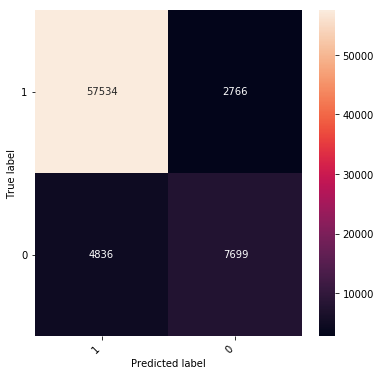

In [21]:
#Using bigrams
count_vect = CountVectorizer(ngram_range=(1,2))
bag_of_words_train = count_vect.fit_transform(x_train)
bag_of_words_test =  count_vect.transform(x_test)
clf = MultinomialNB()
tscv = TimeSeriesSplit(n_splits=10)
paramsearch = GridSearchCV(clf, param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')
paramsearch.fit(bag_of_words_train,y_train)
print('best parameter alpha',paramsearch.best_params_)
pred = paramsearch.predict(bag_of_words_test)

bow_score = roc_auc_score(y_test,pred)
print('AUC score: ',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

 


In [22]:
most_informative_feature(count_vect, paramsearch.best_estimator_)

Negative class
0 -4.162131061319265 tast
0 -4.648621685452725 good
0 -4.705181572897805 like
0 -4.929078304519403 disappoint
0 -5.006724082939913 product
0 -5.064975049053845 flavor
0 -5.170571290117052 bad
0 -5.328781359279843 coffe
0 -5.332597793642076 dont
0 -5.3470405634678935 great
 ************************************* 
Positive class
1 -3.4358261255542484 great
1 -3.892320893972535 good
1 -4.107653267396499 best
1 -4.174774103159887 love
1 -4.614555031799757 tast
1 -4.657626259454631 tea
1 -4.688928725213442 delici
1 -4.759727573713555 coffe
1 -4.8177276787013845 product
1 -5.018631746393298 excel


best parameter alpha {'alpha': 0.1}
AUC score:  0.76
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.74   |  0.57  |   0.64   | 12535.00 |
|      1       |    0.91   |  0.96  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.83   |  0.76  |   0.79   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.88   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


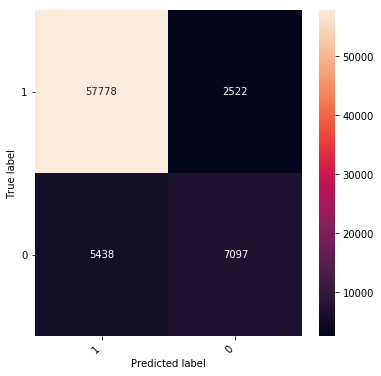

In [23]:
# Unigrams only
count_vect = CountVectorizer()
bag_of_words_train = count_vect.fit_transform(x_train)
bag_of_words_test =  count_vect.transform(x_test)
clf = MultinomialNB()
tscv = TimeSeriesSplit(n_splits=10)
paramsearch = GridSearchCV(clf, param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')
paramsearch.fit(bag_of_words_train,y_train)
print('best parameter alpha',paramsearch.best_params_)
pred = paramsearch.predict(bag_of_words_test)

bow_score = roc_auc_score(y_test,pred)
print('AUC score: ',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

 


In [24]:
most_informative_feature(count_vect, paramsearch.best_estimator_)

Negative class
0 -3.5853682006980883 tast
0 -4.071858824831549 good
0 -4.128418712276629 like
0 -4.3523154438982266 disappoint
0 -4.429961222318736 product
0 -4.4882121884326684 flavor
0 -4.593808429495875 bad
0 -4.752018498658667 coffe
0 -4.7558349330209 dont
0 -4.770277702846717 great
 ************************************* 
Positive class
1 -2.921476599070166 great
1 -3.3779713674884526 good
1 -3.5933037409124164 best
1 -3.660424576675805 love
1 -4.1002055053156745 tast
1 -4.143276732970548 tea
1 -4.17457919872936 delici
1 -4.245378047229472 coffe
1 -4.303378152217302 product
1 -4.504282219909216 excel


### BernoulliNB for BoW with binary = True

The sklearn documentation for BernoulliNB reads: BernoulliNB is designed for binary/boolean features

So, we will use the BernoulliNB classifier for the Bow using binary = True

AUC score: 0.78
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.74   |  0.61  |   0.67   | 12535.00 |
|      1       |    0.92   |  0.95  |   0.94   | 60300.00 |
|  micro avg   |    0.90   |  0.90  |   0.90   | 72835.00 |
|  macro avg   |    0.83   |  0.78  |   0.80   | 72835.00 |
| weighted avg |    0.89   |  0.90  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


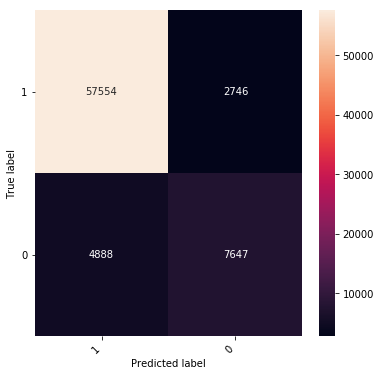

In [25]:
#including bigrams
classifier = Pipeline([
    ('Vectorizer', CountVectorizer(ngram_range=(1,2),binary=True)),
    ('clf', GridSearchCV(BernoulliNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


AUC score: 0.76
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.74   |  0.57  |   0.64   | 12535.00 |
|      1       |    0.91   |  0.96  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.83   |  0.76  |   0.79   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


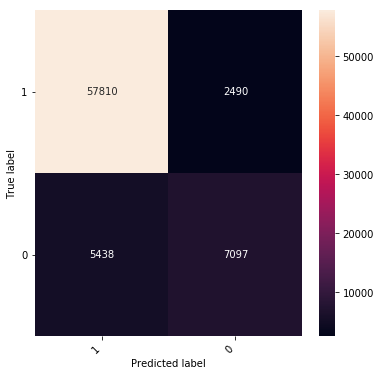

In [26]:
#including unigrams only
classifier = Pipeline([
    ('Vectorizer', CountVectorizer(binary=True)),
    ('clf', GridSearchCV(BernoulliNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


### MultinomialNB for BoW including summary length as another feature

AUC score: 0.76
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.74   |  0.57  |   0.64   | 12535.00 |
|      1       |    0.91   |  0.96  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.83   |  0.76  |   0.79   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.88   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


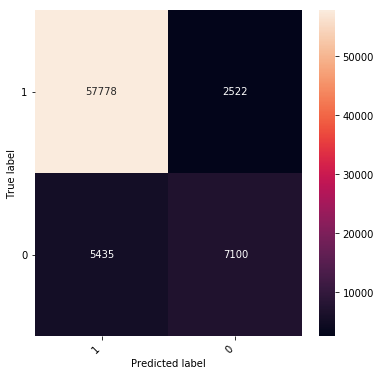

In [27]:
#including summary length as another feature with unigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer()),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(MultinomialNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


AUC score: 0.78
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.74   |  0.61  |   0.67   | 12535.00 |
|      1       |    0.92   |  0.96  |   0.94   | 60300.00 |
|  micro avg   |    0.90   |  0.90  |   0.90   | 72835.00 |
|  macro avg   |    0.83   |  0.78  |   0.80   | 72835.00 |
| weighted avg |    0.89   |  0.90  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


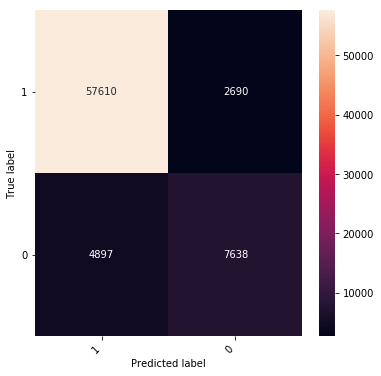

In [28]:
#including summary length as another feature with unigram/bigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(ngram_range=(1,2))),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(MultinomialNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


### BernoulliNB for BoW including summary length

AUC score: 0.76
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.74   |  0.57  |   0.64   | 12535.00 |
|      1       |    0.91   |  0.96  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.83   |  0.76  |   0.79   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


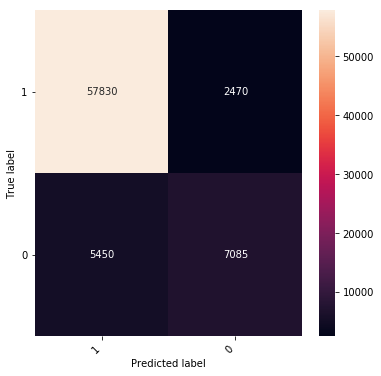

In [29]:
#including summary length as another feature with unigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(binary=True)),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(BernoulliNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


AUC score: 0.78
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.74   |  0.61  |   0.67   | 12535.00 |
|      1       |    0.92   |  0.95  |   0.94   | 60300.00 |
|  micro avg   |    0.90   |  0.90  |   0.90   | 72835.00 |
|  macro avg   |    0.83   |  0.78  |   0.80   | 72835.00 |
| weighted avg |    0.89   |  0.90  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


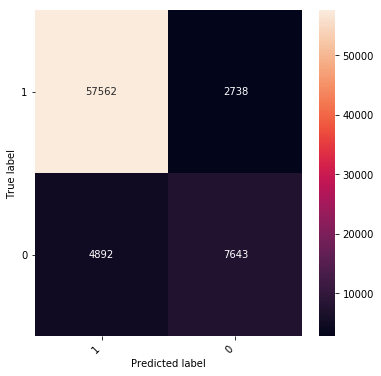

In [30]:
#including summary length as another feature with bigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(binary=True,ngram_range=(1,2))),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(BernoulliNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


### Summary for BoW vectorizer

In [46]:
tab = PrettyTable()
tab.field_names = ["Classifier","Ngram_range","Length included Y/N","AUC"]
list1=["MultinomialNB","1","N","0.76"]
list2=["MultinomialNB","1,2","N","0.78"]
list3=["BernoulliNB","1","N","0.76"]
list4=["BernoulliNB","1,2","N","0.78"]
list5=["MultinomialNB","1","Y","0.76"]
list6=["MultinomialNB","1,2","Y","0.78"]
list7=["BernoulliNB","1","Y","0.76"]
list8=["BernoulliNB","1,2","Y","0.78"]
tab.add_row(list1)
tab.add_row(list2)
tab.add_row(list3)
tab.add_row(list4)
tab.add_row(list5)
tab.add_row(list6)
tab.add_row(list7)
tab.add_row(list8)
print(tab) 

+---------------+-------------+---------------------+------+
|   Classifier  | Ngram_range | Length included Y/N | AUC  |
+---------------+-------------+---------------------+------+
| MultinomialNB |      1      |          N          | 0.76 |
| MultinomialNB |     1,2     |          N          | 0.78 |
|  BernoulliNB  |      1      |          N          | 0.76 |
|  BernoulliNB  |     1,2     |          N          | 0.78 |
| MultinomialNB |      1      |          Y          | 0.76 |
| MultinomialNB |     1,2     |          Y          | 0.78 |
|  BernoulliNB  |      1      |          Y          | 0.76 |
|  BernoulliNB  |     1,2     |          Y          | 0.78 |
+---------------+-------------+---------------------+------+


## Using TF-IDF Vectorizer

### MultinomialNB for Tf-Idf

best parameter alpha {'alpha': 0.1}
AUC score:  0.78
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.82   |  0.54  |   0.65   | 12535.00 |
|      1       |    0.91   |  0.98  |   0.94   | 60300.00 |
|  micro avg   |    0.90   |  0.90  |   0.90   | 72835.00 |
|  macro avg   |    0.86   |  0.76  |   0.80   | 72835.00 |
| weighted avg |    0.89   |  0.90  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


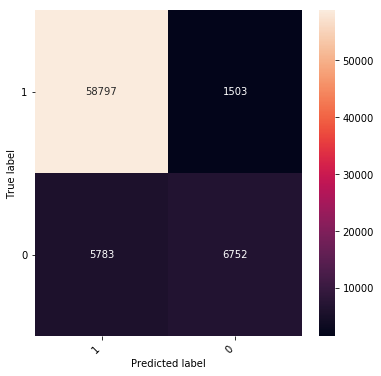

In [31]:
#Using bigrams
vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = vect.fit_transform(x_train)
tfidf_test =  vect.transform(x_test)
clf = MultinomialNB()
tscv = TimeSeriesSplit(n_splits=10)
paramsearch = GridSearchCV(clf, param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')
paramsearch.fit(tfidf_train,y_train)
print('best parameter alpha',paramsearch.best_params_)
pred = paramsearch.predict(tfidf_test)

tfidf_score = roc_auc_score(y_test,pred)
print('AUC score: ',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

 


In [32]:
most_informative_feature(vect, paramsearch.best_estimator_)

Negative class
0 -4.514240690737031 disappoint
0 -4.872769926405842 good
0 -4.9081687136723735 tast
0 -5.4025027279060245 like
0 -5.429708185937914 yuck
0 -5.488588476163143 bad
0 -5.576652461493772 aw
0 -5.584314366122971 terribl
0 -5.629974361157428 horribl
0 -5.651771535279902 flavor
 ************************************* 
Positive class
1 -3.977109498079617 great
1 -4.2698155811305565 love
1 -4.295915387065792 good
1 -4.498206733309955 delici
1 -4.605961472175473 best
1 -4.91714963442063 yummi
1 -5.014721636888629 product
1 -5.060934102915871 excel
1 -5.113736758751314 tea
1 -5.126058923960628 coffe


best parameter alpha {'alpha': 0.1}
AUC score:  0.78
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.82   |  0.46  |   0.59   | 12535.00 |
|      1       |    0.90   |  0.98  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.86   |  0.72  |   0.76   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.88   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


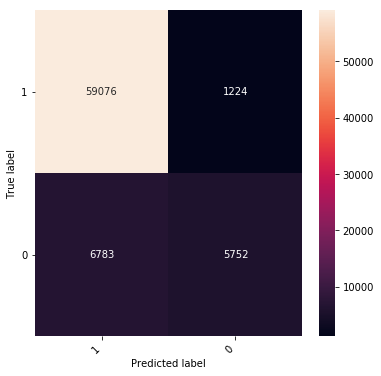

In [33]:
#Using unigrams only
vect = TfidfVectorizer()
tfidf_train = vect.fit_transform(x_train)
tfidf_test =  vect.transform(x_test)
clf = MultinomialNB()
tscv = TimeSeriesSplit(n_splits=10)
paramsearch = GridSearchCV(clf, param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')
paramsearch.fit(tfidf_train,y_train)
print('best parameter alpha',paramsearch.best_params_)
pred = paramsearch.predict(tfidf_test)

tfidf_score = roc_auc_score(y_test,pred)
print('AUC score: ',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

 


In [34]:
most_informative_feature(vect, paramsearch.best_estimator_)

Negative class
0 -3.9930140259038565 disappoint
0 -4.042764986286793 tast
0 -4.232981713111151 good
0 -4.522249170162022 like
0 -4.639110810099506 bad
0 -4.7981475368161535 flavor
0 -4.867584962002007 product
0 -4.875577624484664 terribl
0 -4.9079891831732505 dont
0 -4.929787349828707 buy
 ************************************* 
Positive class
1 -3.2988585114941245 great
1 -3.650644927430511 good
1 -3.731381743527624 love
1 -3.935576727009348 best
1 -4.044748775665127 delici
1 -4.312253799987996 product
1 -4.35779161642971 tea
1 -4.364724268831607 tast
1 -4.386164862552725 coffe
1 -4.474822415540693 excel


### MultinomialNB for Tf-Idf with summary length as additional feature

AUC score: 0.75
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.83   |  0.53  |   0.64   | 12535.00 |
|      1       |    0.91   |  0.98  |   0.94   | 60300.00 |
|  micro avg   |    0.90   |  0.90  |   0.90   | 72835.00 |
|  macro avg   |    0.87   |  0.75  |   0.79   | 72835.00 |
| weighted avg |    0.89   |  0.90  |   0.89   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


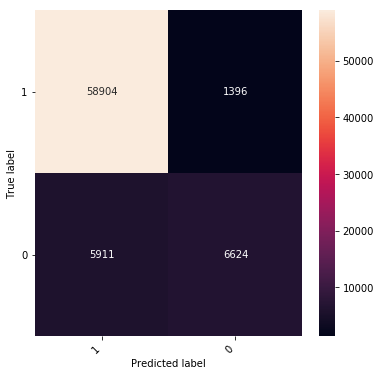

In [35]:
#including summary length as another feature with bigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', TfidfVectorizer(ngram_range=(1,2))),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(MultinomialNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


AUC score: 0.72
Classification report  :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.83   |  0.46  |   0.59   | 12535.00 |
|      1       |    0.90   |  0.98  |   0.94   | 60300.00 |
|  micro avg   |    0.89   |  0.89  |   0.89   | 72835.00 |
|  macro avg   |    0.86   |  0.72  |   0.76   | 72835.00 |
| weighted avg |    0.88   |  0.89  |   0.88   | 72835.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix  :-


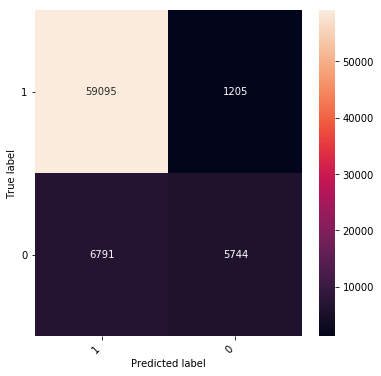

In [36]:
#including summary length as another feature with unigram bow

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', TfidfVectorizer()),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ]))
    ])),
    ('clf', GridSearchCV(MultinomialNB(), param_grid=dict(alpha=[0.1,0.01,0.0001,0.001]), n_jobs=1,cv=tscv,refit='AUC')    )
])

classifier.fit(x_train, y_train)
predicted = classifier.predict(x_test)
bow_score = roc_auc_score(y_test,predicted)
print('AUC score:',round(bow_score,2))
print('Classification report  :-')
bow_dict = metrics.classification_report(y_test,predicted,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix  :-')
print_confusion_matrix(confusion_matrix(y_test, predicted,labels=[1,0]), [1,0])


### Summary for Tf-Idf vectorizer

In [45]:
tab = PrettyTable()
tab.field_names = ["Classifier","Ngram_range","Length included Y/N","AUC"]
list1=["MultinomialNB","1","N","0.78"]
list2=["MultinomialNB","1,2","N","0.78"]
list3=["MultinomialNB","1","Y","0.72"]
list4=["MultinomialNB","1,2","Y","0.75"]
tab.add_row(list1)
tab.add_row(list2)
tab.add_row(list3)
tab.add_row(list4)
print(tab) 

+---------------+-------------+---------------------+------+
|   Classifier  | Ngram_range | Length included Y/N | AUC  |
+---------------+-------------+---------------------+------+
| MultinomialNB |      1      |          N          | 0.78 |
| MultinomialNB |     1,2     |          N          | 0.78 |
| MultinomialNB |      1      |          Y          | 0.72 |
| MultinomialNB |     1,2     |          Y          | 0.75 |
+---------------+-------------+---------------------+------+
